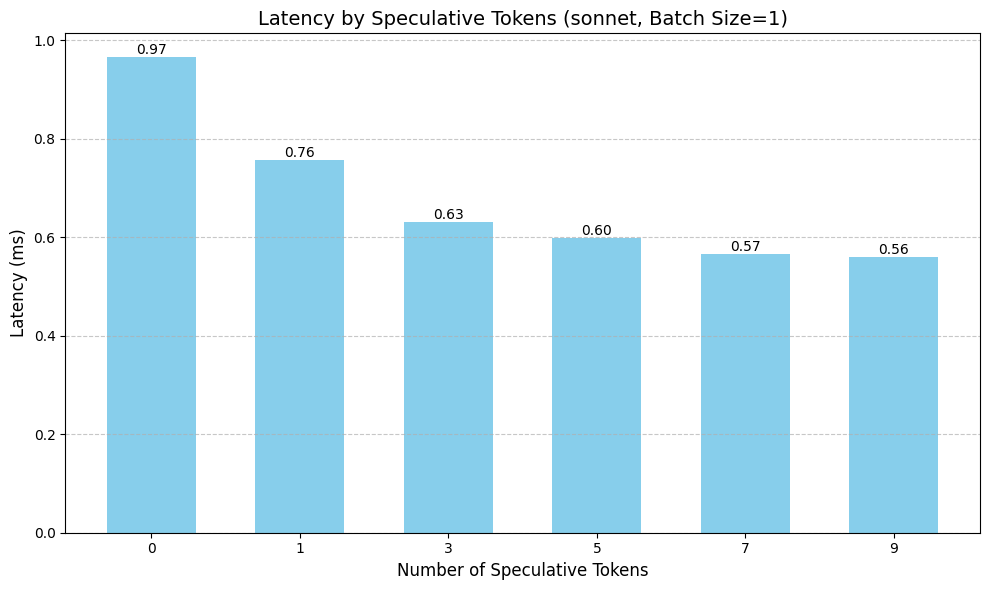

In [1]:
import matplotlib.pyplot as plt
import json

num_speculative_tokens_list = [0, 1, 3, 5, 7, 9]
dataset_name = "sonnet"

batch_size = 1
latencies = {
    nt: json.load(open(f"results/{dataset_name}_batch-size-{batch_size}_ntokens-{nt}.json"))["percentiles"]["50"]
    for nt in num_speculative_tokens_list
}
x_labels = [str(nt) for nt in latencies]  # 将数值转为字符串标签
x_positions = range(len(x_labels))  # 生成均匀分布的 x 坐标

plt.figure(figsize=(10, 6))
bars = plt.bar(x_positions, latencies.values(), width=0.6, color='skyblue')

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.xlabel("Number of Speculative Tokens", fontsize=12)
plt.ylabel("Latency (ms)", fontsize=12)
plt.title(f"Latency by Speculative Tokens ({dataset_name}, Batch Size={batch_size})", fontsize=14)
plt.xticks(x_positions, x_labels)  # 关键：用字符串标签替代数值坐标
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 添加横向网格线

plt.tight_layout()  # 自动调整布局
plt.show()

In [31]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

def get_y_data(entry, label):
    if label == "overhead":
        t = entry['forward_start_time'] - entry['start_time']
    elif label == "verify_time":
        t = entry['forward_end_time'] - entry['forward_start_time']
    elif label == "propose_time":
        t = entry['propose_end_time'] - entry['propose_start_time']
    elif label == "rejection_sampling":
        t = entry['propose_start_time'] - entry['forward_end_time']
    return t * 1000
   
def get_rej_ratio(entry):
    return ((entry['propose_start_time'] - entry['forward_end_time']) / \
              (entry['end_time'] - entry['start_time'])) * 100

def get_propose_ratio(entry):
    return ((entry['propose_end_time'] - entry['propose_start_time']) / \
              (entry['end_time'] - entry['start_time'])) * 100
def get_verify_ratio(entry):
    return ((entry['forward_end_time'] - entry['forward_start_time']) / \
              (entry['end_time'] - entry['start_time'])) * 100

# 1. Load data
y_label = "rejection_sampling"
data = []
with open('profiler_data.jsonl') as f: 
    for line in f:
        entry = json.loads(line)
        data.append({
            y_label: get_y_data(entry, y_label),
            'num_kv_tokens': entry['num_kv_tokens'],
            'num_compute_tokens': entry['num_compute_tokens'],
            'batch_size': entry['batch_size'],
            'enable_spec_decode': entry['num_compute_tokens'] != entry['batch_size'],
            'rej_ratio': get_rej_ratio(entry),
            'propose_ratio': get_propose_ratio(entry),
            'verify_ratio': get_verify_ratio(entry),
        })

df = pd.DataFrame(data)
df 



,rejection_sampling,num_kv_tokens,num_compute_tokens,batch_size,enable_spec_decode,rej_ratio,propose_ratio,verify_ratio
0,1.159430,13,13,1,True,4.677491,0.447262,89.518689
1,1.206636,13,13,1,True,4.874455,0.422819,89.105917
2,1.215696,13,13,1,True,4.508639,0.388173,89.209861
3,1.261711,13,13,1,True,4.674210,0.393051,89.006068
4,0.897408,14,1,1,False,4.437842,0.527023,91.361300
...,...,...,...,...,...,...,...,...
314424,0.594378,543,4,4,False,3.079907,0.660951,93.725292
314425,0.579357,415,3,3,False,3.003114,0.630283,93.952988
314426,0.591516,415,3,3,False,3.064174,0.647169,93.772849
314427,0.591278,415,3,3,False,3.062749,0.644659,93.776938


(0.0, 100.0)

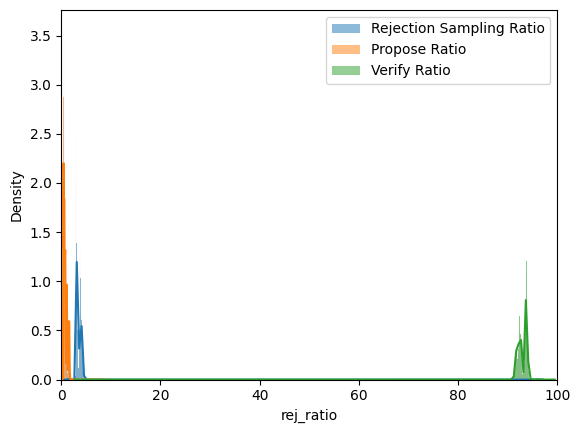

In [33]:
import seaborn as sns
sns.histplot(df['rej_ratio'], kde=True, stat="density", label='Rejection Sampling Ratio')
sns.histplot(df['propose_ratio'], kde=True, stat="density", label='Propose Ratio')
sns.histplot(df['verify_ratio'], kde=True, stat="density", label='Verify Ratio')
plt.legend()
plt.xlim(0, 100)

In [27]:
# 2. prepare data
X = df[['num_kv_tokens', 'num_compute_tokens', 'batch_size', 'enable_spec_decode']]
y = df[y_label]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.2,
                                                            random_state=42)
X_train.head(), y_train.head()

(        num_kv_tokens  num_compute_tokens  batch_size  enable_spec_decode
 308523          14724                  73          53                True
 277047           7754                  32          27                True
 103058          21481                  64          64               False
 10206             132                   1           1               False
 205131             13                  13           1                True,
 308523    0.940800
 277047    0.831366
 103058    0.720739
 10206     0.807047
 205131    0.572681
 Name: rejection_sampling, dtype: float64)


Test R²分数 = 0.0031


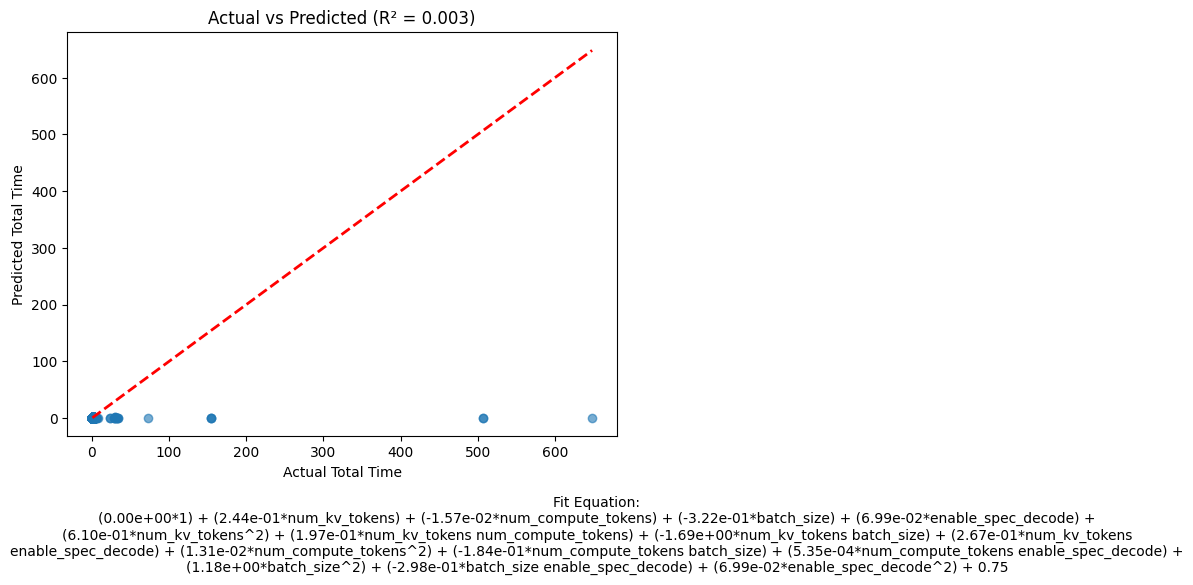

模型结构：
Pipeline(steps=[('poly', PolynomialFeatures()), ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

特征名称（标准化后的多项式特征）：
['1' 'num_kv_tokens' 'num_compute_tokens' 'batch_size'
 'enable_spec_decode' 'num_kv_tokens^2' 'num_kv_tokens num_compute_tokens'
 'num_kv_tokens batch_size' 'num_kv_tokens enable_spec_decode'
 'num_compute_tokens^2' 'num_compute_tokens batch_size'
 'num_compute_tokens enable_spec_decode' 'batch_size^2'
 'batch_size enable_spec_decode' 'enable_spec_decode^2']

R²分数 = 0.0034


In [ ]:
from sklearn.metrics import r2_score
from joblib import dump

# model = LinearRegression(fit_intercept=True)
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                      ('scaler', StandardScaler()),
                      ('regressor', LinearRegression())])
model.fit(X_train, y_train)
dump(model, f'model_{y_label}.joblib')  # 保存模型


# 获取模型参数
coef = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_

# 生成特征名称（包含多项式项）
feature_names = model.named_steps['poly'].get_feature_names_out(
    ['num_kv_tokens', 'num_compute_tokens', 'batch_size', 'enable_spec_decode']
)

# 生成预测值
def score(X, y):
    y_pred = model.predict(X)
    r_squared = r2_score(y, y_pred)
    return y_pred, r_squared

y_test_pred, r_test_squared = score(X_test, y_test)
print(f"\nTest R²分数 = {r_test_squared:.4f}")
    

# 3. 可视化结果
plt.figure(figsize=(12, 5))
y_pred, r_squared = score(X_train, y_train)
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Total Time')
plt.ylabel('Predicted Total Time')
plt.title(f'Actual vs Predicted (R² = {r_squared:.3f})')


plt.tight_layout()

# 显示拟合方程（简略版）
equation = "Fit Equation:\n"
equation += " + ".join([f"({c:.2e}*{name})" for c, name in zip(coef, feature_names)])
equation += f" + {intercept:.2f}"
plt.figtext(0.5, -0.15, equation, ha='center', fontsize=10, wrap=True)

plt.show()

# 打印模型信息
print("模型结构：")
print(model)
print("\n特征名称（标准化后的多项式特征）：")
print(feature_names)
print(f"\nR²分数 = {r_squared:.4f}")